In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, LSTM, Input, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
from urllib.request import urlopen
import urllib.request
import re 

Using TensorFlow backend.


In [3]:
def get_lyrics(artist,song_title):
    artist = artist.lower()
    song_title = song_title.lower()
    # remove all except alphanumeric characters from artist and song_title
    artist = re.sub('[^A-Za-z0-9]+', "", artist)
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title)
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who
        artist = artist[3:]
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html"
    
    try:
        content = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(content, 'html.parser')
        lyrics = str(soup)
        # lyrics lies between up_partition and down_partition
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->'
        down_partition = '<!-- MxM banner -->'
        lyrics = lyrics.split(up_partition)[1]
        lyrics = lyrics.split(down_partition)[0]
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').replace('<br/>','').strip()
        return lyrics
    except Exception as e:
        return "Exception occurred \n" +str(e)

In [4]:

def create_corpus(artist_name):
    url = 'http://lyrics.wikia.com/wiki/' + artist_name
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    count=0
    data=[]

    # Parse the data to get list of songs and urls
    for album in soup.find_all(class_='album-art'):
        count += 1
        for song in album.find_next('ol').children:
            try:
                a = re.search('\:(.*)', song.b.a['href'])
                data.append({
                    'url': song.b.a['href'],
                    'name': a.group(1)
                })
            except:
                continue
    df = pd.DataFrame(data, columns=["url","name"])
    print('Collecting {0} songs for {1}'.format(df.shape[0],artist_name))
    corpus = ''
    for ind, row in df.iterrows():
        #print('Collecting song: {}'.format(row['name']))
        corpus += '\n' + get_lyrics(artist_name,row['name'])
    print('Writing song corpus for {}'.format(artist_name))
    with open(artist_name+"_corpus.txt", "w") as text_file:
        text_file.write(corpus)



In [5]:
artist_name = 'shakespeare'

In [6]:
def get_corpus_sequence(artist_name):
    from pathlib import Path
    my_file = Path(artist_name+'_corpus.txt')
    if not my_file.is_file():
        print('Corpus doesn\'t already exit for {}'.format(artist_name))
        create_corpus(artist_name)
    with open(artist_name+'_corpus.txt','r',encoding='utf8') as f:
        print('Gathering and processing sequence or text')
        text = f.read().lower().replace('\n',' \n ')
    text_seq = [word for word in text.split(' ') if word.strip != '']
    return text_seq

In [12]:
text_seq = get_corpus_sequence(artist_name)
#text = ''.join(text_seq)

Gathering and processing sequence or text


In [13]:
len(text_seq)

19672

In [14]:
# Calculate word frequency
word_freq = {}
for word in text_seq:
    word_freq[word] = word_freq.get(word, 0) + 1
MIN_WORD_FREQUENCY = 1
ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

words = set(text_seq)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))

text_seq = [word for word in text_seq if word not in ignored_words]
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))


Unique words before ignoring: 4381
Ignoring words with frequency < 1
Unique words after ignoring: 4381


In [15]:
# cut the text in semi-redundant sequences of SEQUENCE_LEN words
STEP = 1
SEQUENCE_LEN = 5
sentences = []
next_words = []
ignored = 0
for i in range(0, len(text_seq) - SEQUENCE_LEN, STEP):
    # Only add sequences where no word is in ignored_words
    if len(set(text_seq[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
        sentences.append(text_seq[i: i + SEQUENCE_LEN])
        next_words.append(text_seq[i + SEQUENCE_LEN])
    else:
        ignored = ignored+1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 0
Remaining sequences: 19667


In [16]:
print('Vectorization...')
x = np.zeros((len(sentences), SEQUENCE_LEN, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1
x.shape, y.shape

Vectorization...


((19667, 5, 4381), (19667, 4381))

In [17]:
# build the model: a single LSTM
print('Build model...')
inputs = Input(shape=(SEQUENCE_LEN,len(words)))
X = LSTM(units=128, return_sequences=True)(inputs)
X = Dropout(0.4)(X)
X = LSTM(units=64)(X)
X = Dropout(0.4)(X)
X = Dense(len(words), activation='softmax')(X)

model = Model(inputs=inputs,outputs=X)

Build model...


In [18]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 4381)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            2309120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4381)              284765    
Total params: 2,643,293
Trainable params: 2,643,293
Non-trainable params: 0
_________________________________________________

In [19]:
# Use genrator to create batches of training examples to train the model

In [20]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch%10 == 0:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(text_seq) - SEQUENCE_LEN - 1)
        generated = ''
        sentence = ' '.join(text_seq[start_index: start_index + SEQUENCE_LEN])
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(50):
            x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
            for t, word in enumerate(sentence.split(' ')):
                x_pred[0, t, word_indices[word]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds)
            next_word = indices_word[next_index]

            sentence = ' '.join(sentence.split(' ')[1:]) + ' ' +next_word
    
            sys.stdout.write(' ' + next_word)
            sys.stdout.flush()
        print()

In [22]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model_history = model.fit(x,y,batch_size=64,epochs=100,callbacks=[print_callback])

Epoch 1/100
19667/19667 [==============================] - 81s 4ms/step - loss: 6.8706 - acc: 0.1088

----- Generating text after Epoch: 0
----- Generating with seed: "on better judgment making. 
"
on better judgment making. 
 
 the world so thou very me yet, beauty's you large mind their so drinks fear the and afresh deeds clouds with doth that show under and plot and is to let abundance keep 'will,' sweets in with 
 wretched be? 
 perusal eyes, i thee sight, myself and canst
Epoch 2/100
19667/19667 [==============================] - 78s 4ms/step - loss: 6.4671 - acc: 0.1097
Epoch 3/100
19667/19667 [==============================] - 80s 4ms/step - loss: 6.3725 - acc: 0.1096
Epoch 4/100
19667/19667 [==============================] - 79s 4ms/step - loss: 6.2599 - acc: 0.1096
Epoch 5/100
19667/19667 [==============================] - 85s 4ms/step - loss: 6.1486 - acc: 0.1097
Epoch 6/100
19667/19667 [==============================] - 82s 4ms/step - loss: 6.0245 - acc: 0.1097
Epoch 7/100
1

19667/19667 [==============================] - 64s 3ms/step - loss: 3.0482 - acc: 0.3572
Epoch 61/100
19667/19667 [==============================] - 64s 3ms/step - loss: 3.0167 - acc: 0.3590

----- Generating text after Epoch: 60
----- Generating with seed: "pity me then and wish"
pity me then and wish i eternal him being deem'd to shalt this dost decay. 
 then i have at five welcome, love-god with see governs day to bosom men's 
 with all simple general time? 
 and mourning live to time 
 and eternal new shall friend my variation 
 some nothing. 
 but
Epoch 62/100
19667/19667 [==============================] - 66s 3ms/step - loss: 2.9923 - acc: 0.3589
Epoch 63/100
19667/19667 [==============================] - 67s 3ms/step - loss: 2.9521 - acc: 0.3724
Epoch 64/100
19667/19667 [==============================] - 63s 3ms/step - loss: 2.9139 - acc: 0.3761
Epoch 65/100
19667/19667 [==============================] - 65s 3ms/step - loss: 2.8875 - acc: 0.3828
Epoch 66/100
19667/19667 [=======

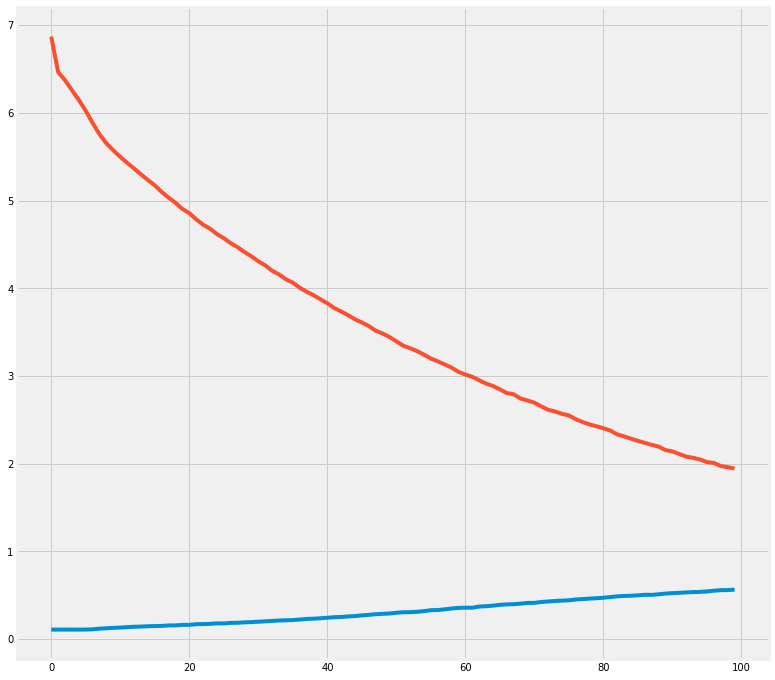

In [23]:
plt.subplots(figsize=(12,12))
sns.lineplot(x=range(100),y=model_history.history['acc'])
sns.lineplot(x=range(100),y=model_history.history['loss'])